In [1]:
import xgboost as xgb
import awkward as ak
import matplotlib.pyplot as plt
import hist
import warnings
import pickle
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import numpy as np
import pickle

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

In [3]:
with open(f'sub_ratios/1291.pkl', 'rb') as f:
    feature_names_1291 = pickle.load(f)

In [4]:
with open(f'sub_ratios/100.pkl', 'rb') as f:
    feature_names_100 = pickle.load(f)

In [5]:
columns_1291 = [f'train_ratios.{i}' for i in feature_names_1291].append('goodjets')

In [6]:
hgg = ak.from_parquet('/scratch365/cmoore24/training/hgg/batch2025/inputs/test/hgg.parquet', 
                      columns=columns_1291)

In [7]:
path = f'/scratch365/cmoore24/training/hgg/batch2025/outputs/bdt/1291'

tagger_bst = xgb.Booster()
tagger_bst.load_model(f'{path}/bdt_model.json')

scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

hgg_np = np.column_stack([ak.to_numpy(hgg.train_ratios[feature]) for feature in feature_names_1291])

hgg_np = scaler.transform(hgg_np)

hgg_xgb = xgb.DMatrix(hgg_np, feature_names=feature_names_1291)

hgg['hgg_scores_1291'] = tagger_bst.predict(hgg_xgb)

In [8]:
path = f'/scratch365/cmoore24/training/hgg/batch2025/outputs/bdt/100'

tagger_bst = xgb.Booster()
tagger_bst.load_model(f'{path}/bdt_model.json')

scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

hgg_np = np.column_stack([ak.to_numpy(hgg.train_ratios[feature]) for feature in feature_names_100])

hgg_np = scaler.transform(hgg_np)

hgg_xgb = xgb.DMatrix(hgg_np, feature_names=feature_names_100)

hgg['hgg_scores_100'] = tagger_bst.predict(hgg_xgb)

In [9]:
path = f'/scratch365/cmoore24/training/hgg/ecf_vs_data/bdt/output/1291'

scaling_bst = xgb.Booster()
scaling_bst.load_model(f'{path}/bdt_model.json')

scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

hgg_np = np.column_stack([ak.to_numpy(hgg.train_ratios[feature]) for feature in feature_names_1291])

hgg_np = scaler.transform(hgg_np)

hgg_xgb = xgb.DMatrix(hgg_np, feature_names=feature_names_1291)

hgg['hgg_scales_1291'] = scaling_bst.predict(hgg_xgb)

In [10]:
path = f'/scratch365/cmoore24/training/hgg/ecf_vs_data/bdt/output/100'

scaling_bst = xgb.Booster()
scaling_bst.load_model(f'{path}/bdt_model.json')

scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

hgg_np = np.column_stack([ak.to_numpy(hgg.train_ratios[feature]) for feature in feature_names_100])

hgg_np = scaler.transform(hgg_np)

hgg_xgb = xgb.DMatrix(hgg_np, feature_names=feature_names_100)

hgg['hgg_scales_100'] = scaling_bst.predict(hgg_xgb)

In [11]:
hgg_weight_1291 = (1-hgg.hgg_scales_1291)/hgg.hgg_scales_1291

In [12]:
hgg_weight_100 = (1-hgg.hgg_scales_100)/hgg.hgg_scales_100

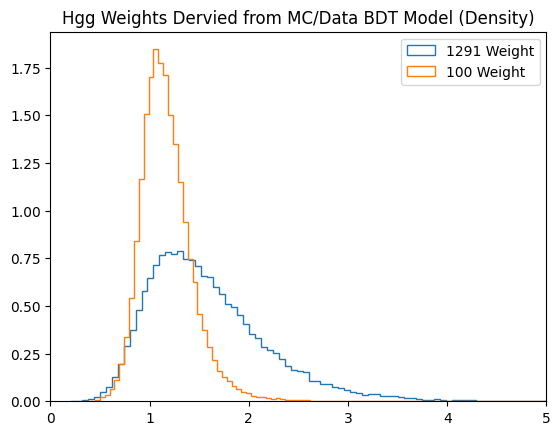

In [13]:
plt.hist(hgg_weight_1291, histtype='step', bins=100, density=True, label='1291 Weight')
plt.hist(hgg_weight_100, histtype='step', bins=100, density=True, label='100 Weight')
plt.legend()
plt.title('Hgg Weights Dervied from MC/Data BDT Model (Density)')
plt.xlim(0, 5)
# plt.axvline(x=1.1)
plt.show()

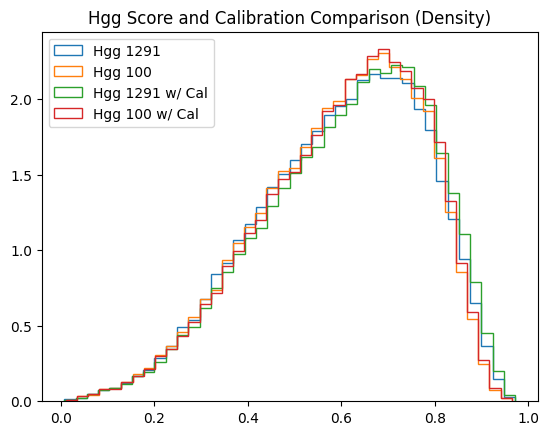

In [14]:
plt.hist(hgg.hgg_scores_1291, bins=40, histtype='step', label='Hgg 1291', density=True)
plt.hist(hgg.hgg_scores_100, bins=40, histtype='step', label='Hgg 100', density=True)
plt.hist(hgg.hgg_scores_1291, bins=40, histtype='step', label='Hgg 1291 w/ Cal', density=True, weights=hgg_weight_1291)
plt.hist(hgg.hgg_scores_100, bins=40, histtype='step', label='Hgg 100 w/ Cal', density=True, weights=hgg_weight_100)
plt.title(f'Hgg Score and Calibration Comparison (Density)')
plt.legend()
plt.show()